# Exploring Generative Adversarial Networks (GANs) with PyTorch and CIFAR-10

This notebook implements a Generative Adversarial Network (GAN) using PyTorch to generate realistic images from the CIFAR-10 dataset. The GAN consists of two neural networks:

1. **Generator**: Creates synthetic images from random noise
2. **Discriminator**: Distinguishes between real and generated images

We'll train these networks in an adversarial manner, where the generator learns to produce increasingly realistic images while the discriminator improves at detecting fakes. The CIFAR-10 dataset, containing 60,000 32x32 color images across 10 classes, serves as our real data distribution.

Key aspects covered:
- GAN architecture implementation in PyTorch
- Training process with adversarial loss functions
- Visualization of generated images during training
- Evaluation of GAN performance on CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from importlib_metadata import version

for package in ['torch', 'torchvision', 'matplotlib', 'numpy']:
    print(f'{package}: {version(package)}')


torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
matplotlib: 3.10.0
numpy: 2.1.1


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device # setting up device agnostic code for gpu usage


'cuda'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])
transform


Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [7]:
train_dataset = datasets.CIFAR10(root="data", \
                                 train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(train_dataset,\
                                        batch_size=32, shuffle=True)



In [8]:
# Hyperparameters
latent_dim = 100 # Dimensionality of the noise vector.
lr = 0.0002
# Adam optim coefficients
beta1 = 0.5
beta2 = 0.999
epochs = 5


In [9]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [11]:
# from torchinfo import summary
from torchsummary import summary
import torch

generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

print(summary(generator, (latent_dim,)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
              ReLU-2                 [-1, 8192]               0
         Unflatten-3            [-1, 128, 8, 8]               0
          Upsample-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]         147,584
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
          Upsample-8          [-1, 128, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          73,792
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12            [-1, 3, 32, 32]           1,731
             Tanh-13            [-1, 3, 32, 32]               0
Total params: 1,050,883
Trainable param

In [13]:
print(summary(discriminator, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
         LeakyReLU-2           [-1, 32, 16, 16]               0
           Dropout-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
         ZeroPad2d-5             [-1, 64, 9, 9]               0
       BatchNorm2d-6             [-1, 64, 9, 9]             128
         LeakyReLU-7             [-1, 64, 9, 9]               0
           Dropout-8             [-1, 64, 9, 9]               0
            Conv2d-9            [-1, 128, 5, 5]          73,856
      BatchNorm2d-10            [-1, 128, 5, 5]             256
        LeakyReLU-11            [-1, 128, 5, 5]               0
          Dropout-12            [-1, 128, 5, 5]               0
           Conv2d-13            [-1, 256, 5, 5]         295,168
      BatchNorm2d-14            [-1, 25

In [14]:
loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


In [15]:
# Training Loop
for epoch in range(epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        # Adverserial truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)

        real_loss = loss(discriminator\
                        (real_images), valid)
        fake_loss = loss(discriminator\
                        (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        #  Train Generator
        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )

     # Save generated images for every epoch
    if epoch % 10 == 0:
        with torch.inference_mode():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)


Epoch [1/5] Batch 100/1563 Discriminator Loss: 0.5134 Generator Loss: 1.3877
Epoch [1/5] Batch 200/1563 Discriminator Loss: 0.8795 Generator Loss: 0.8927
Epoch [1/5] Batch 300/1563 Discriminator Loss: 0.6383 Generator Loss: 0.9409
Epoch [1/5] Batch 400/1563 Discriminator Loss: 0.6869 Generator Loss: 0.9516
Epoch [1/5] Batch 500/1563 Discriminator Loss: 0.6708 Generator Loss: 1.3433
Epoch [1/5] Batch 600/1563 Discriminator Loss: 0.7603 Generator Loss: 0.9908
Epoch [1/5] Batch 700/1563 Discriminator Loss: 0.4921 Generator Loss: 1.2159
Epoch [1/5] Batch 800/1563 Discriminator Loss: 0.7108 Generator Loss: 1.0975
Epoch [1/5] Batch 900/1563 Discriminator Loss: 0.6478 Generator Loss: 0.8779
Epoch [1/5] Batch 1000/1563 Discriminator Loss: 0.7425 Generator Loss: 1.0022
Epoch [1/5] Batch 1100/1563 Discriminator Loss: 0.5849 Generator Loss: 1.2810
Epoch [1/5] Batch 1200/1563 Discriminator Loss: 0.6359 Generator Loss: 0.9852
Epoch [1/5] Batch 1300/1563 Discriminator Loss: 0.8085 Generator Loss: 0.

In [18]:
from pathlib import Path


MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

discr = "discriminator.onnx"
gener = "generator.onnx"


torch.onnx.export(generator, 
                  torch.randn(1, latent_dim, device=device), 
                  MODEL_PATH / gener, 
                  export_params=True, 
                  opset_version=13, 
                  input_names=['input'], 
                  output_names=['output'])

torch.onnx.export(discriminator, 
                  torch.randn(1, 3, 32, 32, device=device), 
                  MODEL_PATH / discr, 
                  export_params=True, 
                  opset_version=13,
                  input_names=['input'], 
                  output_names=['output'])


In [20]:
from pathlib import Path


MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

discr = "discriminator.onnx"
gener = "generator.onnx"

import onnxruntime as ort


# Load the ONNX models
generator_session = ort.InferenceSession(str(MODEL_PATH / gener))
discriminator_session = ort.InferenceSession(str(MODEL_PATH / discr))


*To avoid the issue of constant kernel die-offs as a result of memory overload when directly displaying large tensors, I converted the grid tensor into an image and displayed it using the `imshow` function from matplotlib. This approach is more memory-efficient and prevents kernel crashes.*

In [21]:
# Saving the image grid
from torchvision.utils import save_image

save_image(grid, "generated.png")


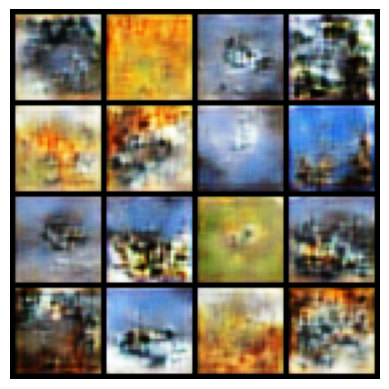

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("generated.png")
plt.imshow(image)
plt.axis("off")
plt.show()
